Réalisé par le groupe : Abla Amharref (GL), Roland Bertin-Johannet (Imagine), Tom Bros (GL), Rihab Haoulani (GL), Manon Ramaroson (IASD)

# Introduction

Dans ce notebook, vous pourrez retrouver un bilan de nos expérimentions sur la détection de fake news. Nous avons fait le choix de ne présenter que les prétraitements et classifications dont les résultats obtenus étaient les plus positifs. 

Nous avons divisé ce notebook en plusieurs sections : 
- Initialisation : comprend les  importations de base et la connexion à notre drive.
- Données : nous chargeons les données et les équilibrons.
- Ingénierie des données : contient la définition de la fonction *preprocess*, ainsi que l'application des meilleurs prétraitements trouvés.
- Méthodes Traditionnelles : nous montrons les classifications les plus satisfaisantes que nous avons pu tester avec les méthodes de classification traditionnelles.
- Deep Learning : nous reproduirons nos résultats avec l'avec l'approche Deep Learning.

# Initialisation

In [1]:
!pip install umap-learn

In [2]:
# Importation des différentes librairies, classes et fonctions utilespour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

# UMAP
import plotly.express as px
from sklearn.datasets import load_digits
from umap import UMAP

# PCA
from sklearn.decomposition import PCA
import plotly.express as px

 # stop-words
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
my_local_drive='/content/gdrive/My Drive/machine_learning'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/machine_learning


'/content/gdrive/My Drive/machine_learning'

In [5]:
# fonctions utilities (affichage, confusion, etc.)
from MyNLPUtilities import *

# Données

Chargement des données.

In [6]:
df = pd.read_csv("claimskg_result.csv")

Equilibrage des données : on réalise de l'undersampling sur la classe faux.

In [7]:
group = df.groupby('truthRating')
vrai = group.get_group(3)
faux = group.get_group(1)
faux = faux.sample(len(vrai))
vrai = vrai.sample(len(vrai))
df = pd.concat([vrai, faux]).reset_index()

On peut voir ci-dessous que nous avons à présent autant de vrais (3) que de faux (1).

In [8]:
df.truthRating.value_counts()

3    2634
1    2634
Name: truthRating, dtype: int64

# Ingénierie des données

La fonction *preprocess*, est une fonction de prétraitement qui prend en argument : 
- les données à traiter
- des booléens pour marquer le retrait des nombres, le retrait des stopwords, appliquer le stemming, retirer la ponctuation, ajouter les auteurs, ajouter les dates ou ajouter les sources.

Elle retourne :
- les données sur lesquelles on a appliqué le prétraitement. 

In [9]:
def preprocess(data,
               remove_nums=False,
               remove_stopwords=False,
               apply_stemming=False,
               remove_punc=False,
               add_authors=False,
               add_dates=False,
               add_sources=False):
  #pour récupérer d'autres colonnes plus tard
  cp = data.copy()

  data = data.text.values
  if remove_nums:
    nonums=[]
    for i in range(len(data)):
      nonums.append(" ".join([word for word in data[i].split() if not word.isnumeric()]))
    nonums=[str(val) for val in nonums]
    data=nonums

  #tokenisation
  data = pd.DataFrame([word_tokenize(doc) for doc in data])

  if remove_stopwords:
    #retirer stop words
    stop = list(stopwords.words("english"))
    nostop = []
    for i in range(len(data)):
      doc = data.iloc[i]
      nostop.append([word for word in doc if word not in stop])
    data = pd.DataFrame(nostop)

  if apply_stemming:
    #stemming
    ps=nltk.stem.porter.PorterStemmer()

    stemmed = []
    for i in range(len(data)):
      doc = data.iloc[i]
      stemmed.append([ps.stem(word) for word in doc if word!=None])
    data = pd.DataFrame(stemmed)

  if remove_punc:
    #retirer ponctuation
    import string

    nopunc = []
    for i in range(len(data)):
      doc = data.iloc[i]
      nopunc.append([word for word in doc if word!=None and word not in string.punctuation])
    data = pd.DataFrame(nopunc)


  #réassemblage
  docs = []
  for i in range(len(data)):
    doc = data.iloc[i]
    docs.append(" ".join([word for word in doc if word!=None]))
  docs = pd.Series(docs)


  #TFIDF
  tv = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
  X = tv.fit_transform(docs)

  #ajout des auteurs, de la date et de la source :
  #get_dummies fait du one-hot-encoding
    
  if add_authors:
    authors = pd.get_dummies(cp['author']).values
    X = np.hstack([X.toarray(), authors])

  if add_dates:
    authors = pd.get_dummies(cp['source']).values
    #nécessaire car on ne sait pas si add_authors a déjà changé X en np array
    xarray = X if add_authors else X.toarray()
    X = np.hstack([xarray, authors])

  if add_sources:
    authors = pd.get_dummies(cp['date']).values
    xarray = X if add_authors or add_dates else X.toarray()
    X = np.hstack([xarray, authors])

  #même idée
  Xret = X.toarray() if not add_authors and not add_dates and not add_sources else X

  return Xret, tv.get_feature_names()

## Prétraitements ayant un effet positif sur nos classifications

Nous appliquons le retrait de la ponctuation :

In [10]:
nopunc = []
for i in range(len(df.text)):
  doc = df.text.iloc[i]
  nopunc.append("".join([word for word in doc if word!=None and word not in string.punctuation]))

Montrons les premiers éléments de nos données après le retrait de la ponctuation :

In [11]:
nopunc[0:5]

['Today if you were raised poor you’re just as likely to stay poor as you were 50 years ago',
 'Yes health data shows that South Africans drink the most in Africa  Africa Check',
 'A bank issued a credit card to a tree',
 'Snitker has been virtually ignored by the major media',
 'One out of 10 minimumwage workers in the US live in Texas']

Dans la cellule suivante, en utilisant TfidfVectorizer nous réalisons les prétraitements suivants : 
- Vectorisation des phrases
- Retrait des stop-words
- Conservation des majuscules

In [12]:
tv = TfidfVectorizer(stop_words='english', lowercase=False)

X = tv.fit_transform(nopunc)

# Méthodes Traditionnelles

utilise les données précédentes avec un traintestsplit

La fonction *launchExperimentations* est une méthode qui permet de lancer plusieurs classificateurs sur un même jeu de données. Elle prend en argument :
- Une liste de classificateurs
- Un jeu de données

Elle retourne un dataframe qui indique pour chaque classificateur et chaque combinaison de prétraitements : 
- l'exactitude
- la précision (une moyenne sur les deux classes)
- le rappel (une moyenne sur les deux classes)
- le f-score

In [13]:

def launchExperimentations(clf_list, df):
  results = pd.DataFrame()
  clfs=[]
  nums=[]
  stop=[]
  stem=[]
  punc=[]
  authors=[]
  dates=[]
  sources=[]
  
  f1score=[]
  accuracy=[]
  precision=[]
  recall=[]
  
  for key,clf in clf_list:
    for remove_nums in [True,False]:
      for remove_stopwords in [True,False]:
        for apply_stemming in [True,False]:
          for remove_punc in [True,False]:
            for add_authors in [True,False]:
              for add_dates in [True,False]:
                for add_sources in [True,False]:
                  data,_=preprocess(df, remove_nums,
                                        remove_stopwords,
                                        apply_stemming,
                                        remove_punc,
                                        add_authors,
                                        add_dates,
                                        add_sources)
                  clf = clone(clf)
                  clfs.append(key)
                  nums.append(remove_nums)
                  stop.append(remove_stopwords)
                  stem.append(apply_stemming)
                  punc.append(remove_punc)
                  authors.append(add_authors)
                  sources.append(add_sources)
                  dates.append(add_dates)
                  
                  sc = getScores(clf, data, df['truthRating'])
                  f1score.append(sc['f1_score'][0])
                  recall.append(sc['recall'][0])
                  accuracy.append(sc['accuracy'][0])
                  precision.append(sc['precision'][0])
                                   
  results['classifieur']=clfs
  results['nums']=nums
  results['stop']=stop
  results['stem']=stem
  results['punc']=punc
  results['authors']=authors
  results['sources']=sources
  results['dates']=dates
  results['accuracy']=accuracy
  results['precision']=precision
  results['recall']=recall
  results['f1score']=f1score
  return results

## Classification avec LogisticRegression

In [14]:
lr = LogisticRegression()
cv = cross_val_score(lr, X, df.truthRating, cv=10)
print(np.mean(cv))

0.6408521583538358


Affichage de la matrice de confusion sur une prédiction avec Logistic Regression.

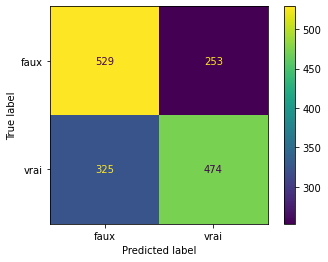

In [15]:
#prédiction
x_train, x_test, y_train, y_test = train_test_split(X, df.truthRating.values,train_size=0.7,
                                               test_size=0.3, shuffle=True)
lr.fit(x_train, y_train)
pred=lr.predict(x_test)
#vp : on a dit 1 et c'est 1.
#fp : on a dit 1 et c'est 0. etc....
vp=0
vn=0
fp=0
fn=0
for i in range(pred.shape[0]):
    if pred[i]==1:
        if y_test[i]==1:
            vn=vn+1
        else:
            fn=fn+1
    elif pred[i]==3:
        if y_test[i]==3:
            vp=vp+1
        else:
            fp=fp+1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, 
                      pred,
                      labels=[1,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["faux","vrai"])
disp.plot()

## Classification avec SVM

Pour SVM, nous réalisons le prétraitement qui a le mieux fonctionné sur nos classifications en utilisant la fonction *preprocess* : 
- Retrait des stop-words
- Retrait de la ponctuation

Cette combinaison de prétraitements a été obtenue grâce à la fonction *launchExperimentations*.

In [16]:
X, _= preprocess(df, remove_nums=False, remove_stopwords=True, remove_punc=True, add_authors=True, add_dates=True, add_sources=False)

Ci-dessous une classification avec SVM. Les paramètres pris en entrées ont été calculés grâce à une gridsearch.

In [17]:
svm = SVC(C=10, gamma=0.01, kernel='rbf')
cv = cross_val_score(svm, X, df.truthRating, cv=10)
print(np.mean(cv))

0.6340242855390654


# Deep Learning

Initialisation de l'environnement pour le Deep Learning.

In [18]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 11 23:05:25 2022

@author: Orlando
"""

import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

import nltk
nltk.download('punkt')
from nltk import word_tokenize

nltk.download("stopwords")
from nltk.corpus import stopwords
stop = list(stopwords.words("english"))

from sklearn.model_selection import train_test_split

import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Chargement des données, le *max_tokens* représente la taille autorisée du vocabulaire.





In [19]:
max_tokens = 1000

textdf = pd.read_csv("claimskg_result.csv")
textdf.head()

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/b0...,GOP presidential candidate Ted Cruz ran a 'Net...,Unknown,1,False,Unknown,Ted Cruz Doesn’t Want to ‘Netflix and Chill’ w...,"Netflix,Netflix and Chill,Republican,Ted Cruz,...","Netflix and Chill,Ted Cruz","politics, ted cruz",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/ted-cruz-net...,English
1,http://data.gesis.org/claimskg/claim_review/03...,A woman managed to call 911 during a domestic ...,Unknown,1,False,Unknown,"In Case of Intruder, Should You Ask 911 for a ...","BuzzFeed,Reddit,Reddit gold,Super Bowl,Super B...",NaN,"911 calls, domestic violence",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/case-intrude...,English
2,http://data.gesis.org/claimskg/claim_review/e1...,The California Department of Public Health has...,Unknown,1,False,Unknown,Measles Parties,"ABCNews.com,California Department of Public He...","California Department of Public Health,measles",ASP Article,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/party-scarred/,English
3,http://data.gesis.org/claimskg/claim_review/3c...,Michelle Obama gorged herself on an expensive ...,Unknown,1,False,Unknown,Michelle Obama and Room Service,"2008. Democratic presidential nominee,Alfred...","Michelle Obama,Waldorf-Astoria hotel,room service","ASP Article, barack obama",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/room-for-error/,English
4,http://data.gesis.org/claimskg/claim_review/b4...,A child injured his arm through extended weari...,Unknown,3,True,Unknown,Silly Bandz Danger,"Associated Press,Bonkers,Facebook,Herendeen,Ne...",Silly Bandz,"ASP Article, Parental Nightmares",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/wrist-risk/,English


Dans la cellule suivante, les opérations effectuées sont : 
- concaténations des champs author, keywords, headline et  source au texte.

Nous les plaçons à la fin des séquences pour ne pas inférer avec la lecture de la première partie (une phrase cohérente) (on le fait en même temps que le reste, dans la boucle ci-dessous)

Nous réalisons également les prétraitements suivants : 
- Retirer les nombres
- Retirer la ponctuation

In [20]:
newDocs = []
for i in range(len(textdf)):
    doc = textdf.text[i]
    doc = doc+' '+str(textdf.author[i])
    doc = doc+' '+str(textdf.keywords[i])
    doc = doc+' '+str(textdf.headline[i])
    doc = doc+' '+str(textdf.source[i])

    #suppression de la ponctuation :
    new_doc = doc.translate(str.maketrans('','',string.punctuation))
   
    #suppression des nombres
    new_doc = "".join([word for word in new_doc if not word.isdigit()])
    
    newDocs.append(new_doc)
textdf["text"]=newDocs

Dans la cellule suivante, nous faisons :
- la Tokenisation du texte avec la taille du vocabulaire spécifiée.
- le rembourage des séquences avec 0 pour qu'elles aient toutes la même taille.



In [21]:
#numérisation
mytokens = Tokenizer(num_words=max_tokens, lower=False)
mytokens.fit_on_texts(textdf.text)
tokenized_text = mytokens.texts_to_sequences(textdf.text)

int_to_word = dict([(i,w) for (w,i) in mytokens.word_index.items()])

encoded_docs = mytokens.texts_to_sequences(textdf.text)

padded_docs = pad_sequences(encoded_docs,maxlen=np.max([len(doc) for doc in encoded_docs]))
print("max length of sequences : ",np.max([len(p) for p in padded_docs]))
print("min length of sequences : ",np.min([len(p) for p in padded_docs]))
print("number of sequences : ",len(padded_docs),"initial number : ",len(textdf.text))

truthvalues = [0 if i==1 else 1 for i in textdf.truthRating]

max length of sequences :  79
min length of sequences :  79
number of sequences :  10000 initial number :  10000


Affichage du texte après les prétraitements et la Tokenisation : 

In [22]:
' '.join([int_to_word[i] for i in encoded_docs[0]])

'GOP presidential candidate Ted Cruz a and on his campaign site Unknown politics Ted Cruz to and with You snopes'

Séparer avant l'oversampling pour éviter un biais :

In [23]:
X_train, X_test,y_train,y_test = train_test_split(padded_docs,truthvalues,test_size=0.3,shuffle=True)

Nous faisons l'oversampling séparément sur les données de test et d'entraînement :

In [24]:
from imblearn.over_sampling import SMOTE
X_train,y_train = SMOTE().fit_resample(X_train,y_train)
X_test,y_test = SMOTE().fit_resample(X_test,y_test)

print("after resampling, train value counts : \n0 :",len([i for i in y_train if i==0]),
      "\n1 :",len([i for i in y_train if i==1]))

after resampling, train value counts : 
0 : 5153 
1 : 5153


Passage des index en one hot vectors :

In [25]:
X = np_utils.to_categorical(X_train)
y = np_utils.to_categorical(y_train,num_classes=2)

Création du modèle :

In [26]:
#model :
model = Sequential()
#model.add(LSTM(255,input_shape=(X.shape[1], X.shape[2]), return_sequences=(True)))
#model.add(Dropout(0.4))
model.add(LSTM(250))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1],activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

Entraînement du modèle :

In [27]:
# fit the model
model.fit(X, y, epochs=3, batch_size=10)

Epoch 1/3
1031/1031 [==============================] - 351s 337ms/step - loss: 0.5712 - accuracy: 0.6942
Epoch 2/3
1031/1031 [==============================] - 325s 316ms/step - loss: 0.4186 - accuracy: 0.7983
Epoch 3/3
1031/1031 [==============================] - 322s 312ms/step - loss: 0.3512 - accuracy: 0.8330


Nous faisons à présent notre évaluation du modèle sur les données de test :

In [28]:
#test it on test data
#first prepare the test data :
X = np_utils.to_categorical(X_test)
y = np_utils.to_categorical(y_test,num_classes=2)

model.evaluate(X,y)

139/139 [==============================] - 27s 192ms/step - loss: 0.4469 - accuracy: 0.7892


[0.4468914568424225, 0.7892001867294312]

Affichage de la matrice de confusion :

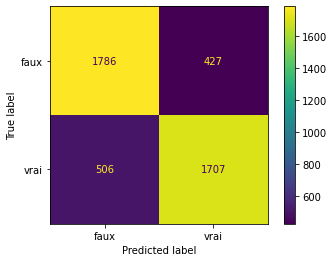

In [29]:
#prédiction
pred = model.predict(X)
#vp : on a dit 1 et c'est 1.
#fp : on a dit 1 et c'est 0. etc....
vp=0
vn=0
fp=0
fn=0
for i in range(pred.shape[0]):
    if np.argmax(pred[i])==0:
        if np.argmax(y[i])==0:
            vn=vn+1
        else:
            fn=fn+1
    elif np.argmax(pred[i])==1:
        if 1==np.argmax(y[i]):
            vp=vp+1
        else:
            fp=fp+1

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix([np.argmax(Y) for Y in y], 
                      [np.argmax(p) for p in pred],
                      labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["faux","vrai"])
disp.plot()